In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from laplace_hdc_helper import load_dataset
from laplace_hdc_encoder_CIFAR10 import hdc_encoder
from laplace_hdc_classifier_CIFAR10 import train_hdc_classifier, test_hdc_classifier
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from scipy.io import savemat, loadmat

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device:\t{device}")


Using device:	cuda:0


### Hyperparameters

In [2]:
hyperdim = 5000 
bandwidth_parameter = 3 # bandwidth parameter
encoder_mode = 'shift_1d'
classifier_mode="float_sgd"
epochs=10

## Load Data

In [3]:
class_names = np.array(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])

# load the MNIST training data
train_data = datasets.CIFAR10(
    '../../Data',
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

# Load the MNIST testing data
test_data = datasets.CIFAR10(
    '../../Data',
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

num_classes = len(class_names)
print(num_classes)

Files already downloaded and verified
Files already downloaded and verified
10


## Kernel Matrix Construction

lambda = 0.0035261260345578194


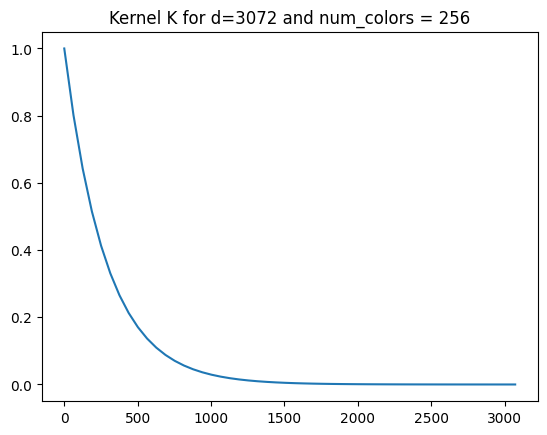

In [4]:
# Determining Lambda from random 1000 samples
batch_size = 1024
num_colors = 256

X,  _ = next(iter(DataLoader(train_data, batch_size=1000, shuffle=True)))
X = X.reshape(X.shape[0],-1)

D = torch.sum(torch.abs(X.unsqueeze(0)-X.unsqueeze(1)),dim=2)
a = torch.median(D.flatten())
lmd = bandwidth_parameter/a
print(f"lambda = {lmd}")

# Define the local kernel
x = np.linspace(0, 1, num=num_colors).reshape(-1, 1)
f = lambda X: 1 - lmd*X
kernel = f(np.abs(x - x.T))

# Visualize the global kernel
d = train_data[0][0].squeeze().numel()
S = lambda v: np.exp(-lmd*v)
v = np.linspace(0, d)
plt.plot(v, S(v))
plt.title(f"Kernel K for d={d} and num_colors = {num_colors}")
plt.show()

## Create Encoder

In [5]:
encoder = hdc_encoder(d, hyperdim, kernel, encoder_mode)
print(f"mode: {encoder_mode}\nHyperdimension: {encoder.hyperdim}")

mode: shift_1d
Hyperdimension: 5000


## Encode Data

In [6]:
batch_size = 32
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

## Classification

In [7]:
hyperdims = loadmat('../EHDGNet_CIFAR10_nHD.mat')['EHDGNet_CIFAR10_nHD']
hyperdims = np.mean(hyperdims, axis=1, dtype=int)
hyperdims = hyperdims

In [8]:
num_workers  = 2
pin_memory   = True
n_splits     = 20
split_size   = len(test_data) // n_splits
accuracies   = np.zeros((len(hyperdims), n_splits))

for i, nHD in enumerate(hyperdims):
    print(f'Hyperdimension: {nHD} Started --------------')

    encoder          = hdc_encoder(d, nHD, kernel, encoder_mode)
    train_hdc        = encoder.encode(train_loader)
    train_loader_hdc = DataLoader(
        train_hdc,
        batch_size=512,
        shuffle=True,
        num_workers=0,
        pin_memory=False
    )
    model = train_hdc_classifier(
        train_loader_hdc,
        num_classes,
        mode=classifier_mode,
        epochs=10
    )
    print(f'Encoding Train Data and Training the Model for nHD={nHD} finished')

    del train_hdc, train_loader_hdc
    torch.cuda.empty_cache()

    for split_idx in tqdm(range(n_splits)):
        start_idx    = split_idx * split_size
        end_idx      = start_idx + split_size
        split_subset = Subset(test_data, range(start_idx, end_idx))
        split_loader = DataLoader(
            split_subset,
            batch_size=32,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory
        )

        # encode that split
        split_hdc        = encoder.encode(split_loader)
        split_loader_hdc = DataLoader(
            split_hdc,
            batch_size=512,
            shuffle=False,
            num_workers=0,
            pin_memory=False
        )

        # evaluate
        accuracies[i, split_idx] = test_hdc_classifier(model, split_loader_hdc)

        # free this split’s hypervector dataset & loader
        del split_hdc, split_loader_hdc
        torch.cuda.empty_cache()

    # ────────────────────────────────────────────
    # 3) Done with this hyperdim entirely
    del encoder
    torch.cuda.empty_cache()

    print(
        f'Hyperdimension: {nHD} Finished. '
        f'Average Accuracy over {n_splits} splits: {accuracies[i].mean():.4f}'
    )


Hyperdimension: 15000 Started --------------


Float‐SGD: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Encoding Train Data and Training the Model for nHDC=15000 finished


100%|██████████| 20/20 [01:02<00:00,  3.13s/it]


Hyperdimension: 15000 Finished. Average Accuracy over 20 splits: 0.3638
Hyperdimension: 17250 Started --------------


Float‐SGD: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Encoding Train Data and Training the Model for nHDC=17250 finished


100%|██████████| 20/20 [00:46<00:00,  2.34s/it]


Hyperdimension: 17250 Finished. Average Accuracy over 20 splits: 0.3891
Hyperdimension: 19000 Started --------------


Float‐SGD: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Encoding Train Data and Training the Model for nHDC=19000 finished


100%|██████████| 20/20 [00:41<00:00,  2.09s/it]


Hyperdimension: 19000 Finished. Average Accuracy over 20 splits: 0.4159
Hyperdimension: 21250 Started --------------


Float‐SGD: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Encoding Train Data and Training the Model for nHDC=21250 finished


100%|██████████| 20/20 [00:43<00:00,  2.20s/it]


Hyperdimension: 21250 Finished. Average Accuracy over 20 splits: 0.3731
Hyperdimension: 23250 Started --------------


Float‐SGD: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Encoding Train Data and Training the Model for nHDC=23250 finished


100%|██████████| 20/20 [00:43<00:00,  2.18s/it]


Hyperdimension: 23250 Finished. Average Accuracy over 20 splits: 0.4119
Hyperdimension: 25250 Started --------------


Float‐SGD: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Encoding Train Data and Training the Model for nHDC=25250 finished


100%|██████████| 20/20 [00:46<00:00,  2.34s/it]


Hyperdimension: 25250 Finished. Average Accuracy over 20 splits: 0.4174
Hyperdimension: 27000 Started --------------


Float‐SGD: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Encoding Train Data and Training the Model for nHDC=27000 finished


100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


Hyperdimension: 27000 Finished. Average Accuracy over 20 splits: 0.3923
Hyperdimension: 29000 Started --------------


Float‐SGD: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Encoding Train Data and Training the Model for nHDC=29000 finished


100%|██████████| 20/20 [00:57<00:00,  2.86s/it]


Hyperdimension: 29000 Finished. Average Accuracy over 20 splits: 0.4108
Hyperdimension: 31000 Started --------------


Float‐SGD: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Encoding Train Data and Training the Model for nHDC=31000 finished


100%|██████████| 20/20 [01:03<00:00,  3.20s/it]


Hyperdimension: 31000 Finished. Average Accuracy over 20 splits: 0.4271
Hyperdimension: 33000 Started --------------


Float‐SGD: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


Encoding Train Data and Training the Model for nHDC=33000 finished


100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


Hyperdimension: 33000 Finished. Average Accuracy over 20 splits: 0.4285
Hyperdimension: 35000 Started --------------


Float‐SGD: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Encoding Train Data and Training the Model for nHDC=35000 finished


100%|██████████| 20/20 [01:17<00:00,  3.90s/it]

Hyperdimension: 35000 Finished. Average Accuracy over 20 splits: 0.4416


In [9]:
accuracies

array([[0.324, 0.414, 0.348, 0.35 , 0.392, 0.372, 0.324, 0.374, 0.402,
        0.354, 0.362, 0.36 , 0.35 , 0.366, 0.382, 0.366, 0.342, 0.404,
        0.342, 0.348],
       [0.394, 0.44 , 0.378, 0.368, 0.382, 0.392, 0.392, 0.368, 0.418,
        0.39 , 0.384, 0.368, 0.4  , 0.402, 0.398, 0.38 , 0.368, 0.412,
        0.396, 0.352],
       [0.41 , 0.422, 0.406, 0.434, 0.426, 0.392, 0.396, 0.436, 0.47 ,
        0.418, 0.432, 0.374, 0.408, 0.382, 0.446, 0.426, 0.402, 0.444,
        0.404, 0.39 ],
       [0.354, 0.364, 0.382, 0.416, 0.42 , 0.358, 0.376, 0.364, 0.386,
        0.36 , 0.354, 0.342, 0.356, 0.372, 0.374, 0.394, 0.356, 0.38 ,
        0.372, 0.382],
       [0.398, 0.402, 0.42 , 0.416, 0.454, 0.376, 0.412, 0.434, 0.426,
        0.426, 0.372, 0.388, 0.4  , 0.426, 0.42 , 0.426, 0.376, 0.442,
        0.412, 0.412],
       [0.416, 0.438, 0.452, 0.434, 0.444, 0.388, 0.404, 0.456, 0.462,
        0.374, 0.38 , 0.412, 0.398, 0.41 , 0.476, 0.408, 0.376, 0.432,
        0.404, 0.384],
       [0.

In [10]:
savemat('LaplaceHDC_CIFAR10.mat', {'LaplaceHDC_CIFAR10': accuracies*100})

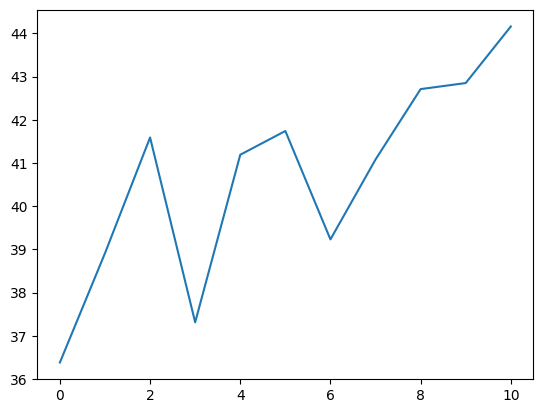

In [11]:
import matplotlib.pyplot as plt
plt.plot(np.mean(accuracies*100, axis=1))

In [12]:
np.std(accuracies*100, axis=1)

array([2.4510406 , 1.98037875, 2.33792643, 1.96313525, 2.1545069 ,
       2.96789488, 2.71534528, 2.20943432, 1.56393734, 2.32196038,
       1.92104138])